# Thêm thư viện cần thiết


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 34.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [4]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/eth/ethereum_train_8_2.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.23180,0.24981,0.23085,0.24797,11970598,USD
2020-06-02,0.24801,0.25321,0.22795,0.23794,12686011,USD
2020-06-03,0.23790,0.24476,0.23384,0.24452,8151002,USD
2020-06-04,0.24453,0.24641,0.23668,0.24337,8749785,USD
2020-06-05,0.24337,0.24750,0.23970,0.24023,7754761,USD


In [5]:
train = train_ETH[["Close"]]
train.head(5)

,Close
Date,
2020-06-01,0.24797
2020-06-02,0.23794
2020-06-03,0.24452
2020-06-04,0.24337
2020-06-05,0.24023


In [6]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/eth/ethereum_test_8_2.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-01-07,3.40722,3.41326,3.07730,3.19531,979252,USD
2022-01-08,3.19814,3.24446,3.00176,3.08002,566062,USD
2022-01-09,3.07989,3.21034,3.06047,3.15030,415868,USD
2022-01-10,3.15027,3.17996,2.93168,3.08543,804376,USD
2022-01-11,3.08464,3.26278,3.05340,3.23789,505208,USD


In [7]:
test = test_ETH[["Close"]]
test.head(5)

,Close
Date,
2022-01-07,3.19531
2022-01-08,3.08002
2022-01-09,3.15030
2022-01-10,3.08543
2022-01-11,3.23789


In [8]:
df = pd.concat([train.reset_index(level=0), test.reset_index(level=0)],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.index=df.Date
df.drop("Date", axis=1, inplace=True)
df.head(5)    

,Close
Date,
2020-06-01,0.24797
2020-06-02,0.23794
2020-06-03,0.24452
2020-06-04,0.24337
2020-06-05,0.24023


# Vẽ đồ thị

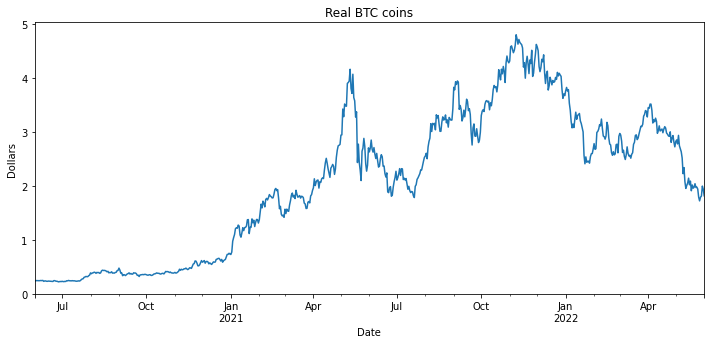

In [9]:
# Thư viện vẽ đồ thị
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real BTC coins'
ylabel='Dollars'
xlabel='Date' 

ax = df['Close'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Kiểm tra tính dừng của chuỗi

In [10]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [11]:
adf_test(df['Close'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.625923
p-value                     0.469625
Number of lags used         6.000000
Number of observations    724.000000
critical value (1%)        -3.439414
critical value (5%)        -2.865540
critical value (10%)       -2.568900
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [12]:
df['diff1'] = df['Close'].diff()
df.head()


,Close,diff1
Date,,
2020-06-01,0.24797,NaN
2020-06-02,0.23794,-0.01003
2020-06-03,0.24452,0.00658
2020-06-04,0.24337,-0.00115
2020-06-05,0.24023,-0.00314


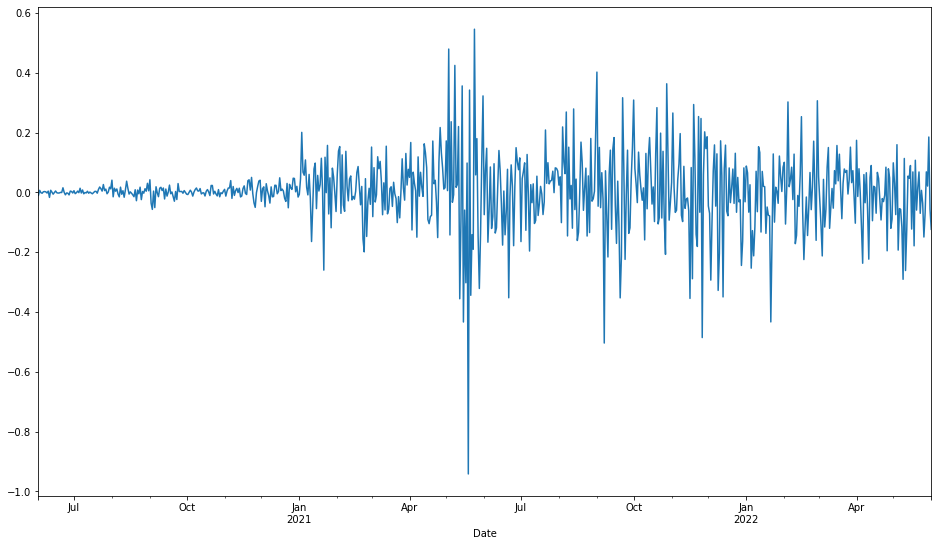

In [13]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [14]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic       -1.016000e+01
p-value                   7.551945e-18
Number of lags used       5.000000e+00
Number of observations    7.240000e+02
critical value (1%)      -3.439414e+00
critical value (5%)      -2.865540e+00
critical value (10%)     -2.568900e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [15]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Close'] = scaler.fit_transform(df_scaled['Close'].values.reshape(-1, 1))
df_scaled.head()

,Close
Date,
2020-06-01,-1.385862
2020-06-02,-1.393427
2020-06-03,-1.388465
2020-06-04,-1.389332
2020-06-05,-1.391700


## Chia dữ liệu thành tập train và tập test

In [16]:
interrupt = len(train)
interrupt

585

In [17]:
index_test = df_scaled.index[interrupt:]
print(train.shape)
print(test.shape)
print(index_test.shape)

(585, 1)
(146, 1)
(146,)


In [18]:
train.tail()

,Close
Date,
2022-01-02,3.83067
2022-01-03,3.76424
2022-01-04,3.78952
2022-01-05,3.53586
2022-01-06,3.40777


In [19]:
test.head()

,Close
Date,
2022-01-07,3.19531
2022-01-08,3.08002
2022-01-09,3.15030
2022-01-10,3.08543
2022-01-11,3.23789


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [20]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [21]:
fitted = arima_model(train)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-815.975, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-810.750, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-817.789, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-817.521, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-811.573, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-815.837, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-818.811, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-813.829, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-817.968, Time=2.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-815.782, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-819.500, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-817.962, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-818.267, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-814.342, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  585
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 412.750
Date:                Sat, 25 Jun 2022   AIC                           -819.500
Time:                        16:03:08   BIC                           -806.390
Sample:                             0   HQIC                          -814.390
                                - 585                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8305      0.076    -10.892      0.000      -0.980      -0.681
ma.L1          0.7507      0.095      7.866      0.000       0.564       0.938
sigma2         0.0142      0.000     35.769      0.000       0.013       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):              1765.90
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):              77.10   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [22]:
pred = fitted.predict(len(test))
pred


array([3.40014511, 3.40647761, 3.40121845, 3.4055862 , 3.40195877,
       3.40497136, 3.40246939, 3.40454729, 3.40282159, 3.40425479,
       3.40306451, 3.40405304, 3.40323206, 3.40391389, 3.40334763,
       3.40381791, 3.40342734, 3.40375171, 3.40348232, 3.40370605,
       3.40352024, 3.40367455, 3.4035464 , 3.40365283, 3.40356444,
       3.40363785, 3.40357688, 3.40362751, 3.40358546, 3.40362039,
       3.40359138, 3.40361547, 3.40359546, 3.40361208, 3.40359828,
       3.40360974, 3.40360022, 3.40360813, 3.40360156, 3.40360701,
       3.40360249, 3.40360625, 3.40360312, 3.40360572, 3.40360356,
       3.40360535, 3.40360387, 3.4036051 , 3.40360408, 3.40360493,
       3.40360422, 3.40360481, 3.40360432, 3.40360472, 3.40360439,
       3.40360467, 3.40360444, 3.40360463, 3.40360447, 3.4036046 ,
       3.40360449, 3.40360458, 3.40360451, 3.40360457, 3.40360452,
       3.40360456, 3.40360452, 3.40360455, 3.40360453, 3.40360455,
       3.40360453, 3.40360455, 3.40360454, 3.40360455, 3.40360

# Vẽ đồ thị cho tập test và kết quả dự đoán

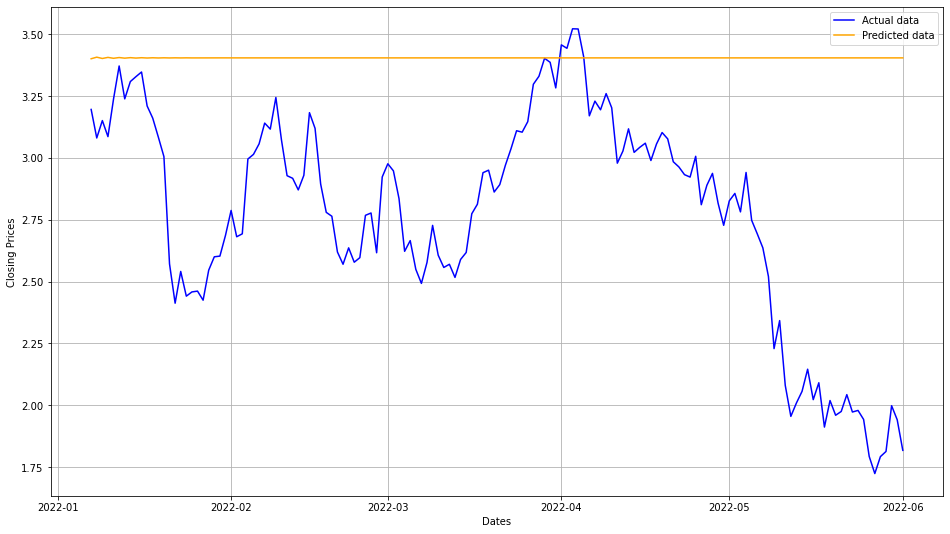

In [23]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [24]:
actual = column_or_1d(test)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


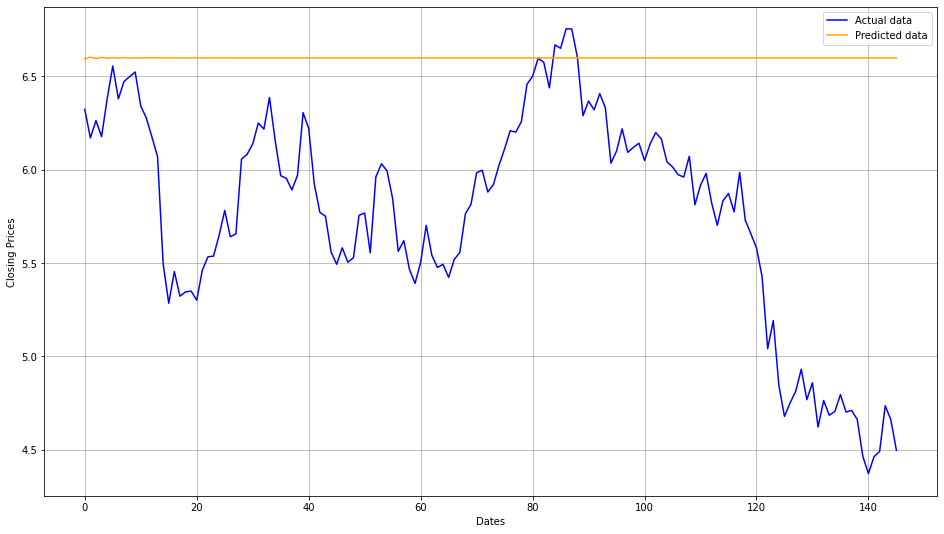

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_actual, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [26]:
# mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_actual, inv_pred)

# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MAPE: 15.93%
RMSE: 1.02
R2: -2.14
